## Pregunta 2: Redes recurrentes sobre texto

> **Parte a)**

In [0]:
import numpy as np
from collections import Counter
import operator
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer

from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout

In [54]:
link = 'http://vps.csaldias.cl/ner.csv'
df_ner = pd.read_csv(link, error_bad_lines=False, encoding='Latin-1')
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [55]:
df_ner.head()

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [0]:
dataset = df_ner.loc[:, ["lemma", "pos", "tag", "prev-iob"]]

In [0]:
dataX,dataY = [],[]
#uniques
lemmas,labels = set(), set()
sentence= []
label_sentence = []

for fila in dataset.values:
    if fila[-1]=="__START1__": 
        dataX.append(np.asarray(sentence))
        dataY.append(np.asarray(label_sentence))
        sentence= []
        label_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[1])
    sentence.append(fila[0])#add lemma
    label_sentence.append(fila[1]) #POS o TAG
#data to  array
dataX = np.asarray(dataX[1:])
dataY = np.asarray(dataY[1:])

> **Parte b)**

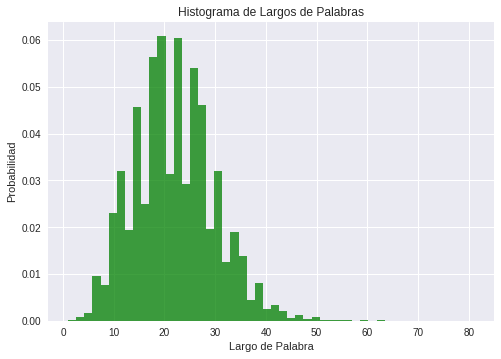

In [58]:
length = lambda x: len(x)
vfunc = np.vectorize(length)
word_lenghts = vfunc(dataX)

n, bins, patches = plt.hist(word_lenghts, 50, density=True, facecolor='g', alpha=0.75)

plt.xlabel('Largo de Palabra')
plt.ylabel('Probabilidad')
plt.title('Histograma de Largos de Palabras')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)
plt.show()

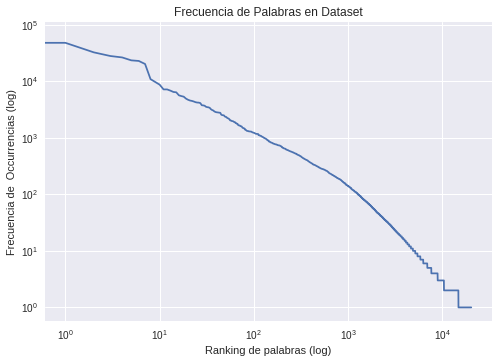

In [59]:
word_freq = {}
for i in dataX:
    for j in i:
        if j in word_freq:
            word_freq[j] += 1
        else:
            word_freq[j] = 1

sorted_freq = (sorted(word_freq.items(), key = operator.itemgetter(1), reverse=True))

just_the_occur = []
just_the_rank = []

entry_num = 0
for entry in sorted_freq:
    just_the_rank.append(entry_num)
    entry_num += 1
    just_the_occur.append(entry[1])

plt.title("Frecuencia de Palabras en Dataset")
plt.ylabel("Frecuencia de  Occurrencias (log)")
plt.xlabel("Ranking de palabras (log)")
plt.loglog(
    just_the_rank,
    just_the_occur,
    basex=10
)
plt.show()

> **Parte c)**

In [70]:
max_length = 0
for palabra in dataX:
    max_length = max(len(palabra), max_length)
print(max_length)

81


In [0]:
#lemma -> ENDLEMMA
lemmas.add("ENDLEMMA")
#labels -> ENDLABELS
labels.add("ENDLABELS")
lemma2idx = {w: i for i, w in enumerate(lemmas)} #Converting text to numbers
lab2idx = {t: i for i, t in enumerate(labels)}
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX]
dataY = [[lab2idx[pos] for pos in pos_tags ] for pos_tags in dataY]
n_lemmas = len(lemmas)
n_labels = len(labels)

In [0]:
X = sequence.pad_sequences(dataX,maxlen=max_length,padding='post',value=lemma2idx["ENDLEMMA"]) 
y = sequence.pad_sequences(dataY,maxlen=max_length,padding='post',value=lab2idx["ENDLABELS"])

In [63]:
print(X[0])

[11661  2065  4499  8465  5834 10312 17666  5449 18784 11901 19491  8544
  9291 10212  6932 11901 18292  2065 17508 11712   655  6446 18867 20023
  6112  6112  6112  6112  6112  6112  6112  6112  6112  6112  6112  6112
  6112  6112  6112  6112  6112  6112  6112  6112  6112  6112  6112  6112
  6112  6112  6112  6112  6112  6112  6112  6112  6112  6112  6112  6112
  6112  6112  6112  6112  6112  6112  6112  6112  6112  6112  6112  6112
  6112  6112  6112  6112  6112  6112  6112  6112  6112]


> **Parte e)**

In [0]:
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)

> **Parte f)**

In [85]:
embedding_vector = 32
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_length))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
scores = model.evaluate(X_test, y_test, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 32)            647808    
_________________________________________________________________
lstm_1 (LSTM)                (None, 81, 100)           53200     
_________________________________________________________________
dense_1 (Dense)              (None, 81, 42)            4242      
Total params: 705,250
Trainable params: 705,250
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 120s 4ms/step - loss: 1.0635 - acc: 0.7546 - val_loss: 0.7581 - val_acc: 0.8007
Epoch 2/3
28032/33656 [=======================>......] - ETA: 18s - loss: 0.6208 - acc: 0.8401

33656/33656 [==============================] - 120s 4ms/step - loss: 0.5854 - acc: 0.8478 - val_loss: 0.3811 - val_acc: 0.8930
Epoch 3/3
33656/33656 [==============================] - 120s 4ms/step - loss: 0.2514 - acc: 0.9327 - val_loss: 0.1654 - val_acc: 0.9572


In [94]:
print("Loss: {:.4f}".format(scores[0]))
print("Accuracy: {:.2f}%".format(scores[1]*100))

Loss: 0.1654
Accuracy: 95.72%


In [92]:
scores

[0.16535402641862476, 0.9572064965105965]

> **Parte g)**

In [100]:
n_vector = 5
embedding_vectors = np.logspace(start=0, stop=4, num=n_vector, base=10).astype(int)
print(embedding_vectors)
loss = {}
acc = {}
exec_time = {}
for embedding_vector in embedding_vectors:
    print("embedding_vector={}".format(embedding_vector))
    model = Sequential()
    model.add(Embedding(input_dim=n_lemmas, output_dim=embedding_vector, input_length=max_length))
    model.add(LSTM(units=100,return_sequences=True))
    model.add(Dense(n_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    start = timer()
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
    end = timer()
    scores = model.evaluate(X_test, y_test, verbose=0)
    loss[embedding_vector] = scores[0]
    acc[embedding_vector] = scores[1]
    exec_time[embedding_vector] = end - start

[    1    10   100  1000 10000]
embedding_vector=1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 81, 1)             20244     
_________________________________________________________________
lstm_2 (LSTM)                (None, 81, 100)           40800     
_________________________________________________________________
dense_2 (Dense)              (None, 81, 42)            4242      
Total params: 65,286
Trainable params: 65,286
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
13568/33656 [===========>..................] - ETA: 1:00 - loss: 1.4941 - acc: 0.7253

33656/33656 [==============================] - 111s 3ms/step - loss: 1.1865 - acc: 0.7338 - val_loss: 0.9108 - val_acc: 0.7497
Epoch 2/3
33656/33656 [==============================] - 110s 3ms/step - loss: 0.8328 - acc: 0.7659 - val_loss: 0.7822 - val_acc: 0.7775
Epoch 3/3
 9984/33656 [=======>......................] - ETA: 1:10 - loss: 0.7681 - acc: 0.7799

33656/33656 [==============================] - 110s 3ms/step - loss: 0.7445 - acc: 0.7907 - val_loss: 0.7057 - val_acc: 0.8087
embedding_vector=10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 81, 10)            202440    
_________________________________________________________________
lstm_3 (LSTM)                (None, 81, 100)           44400     
_________________________________________________________________
dense_3 (Dense)              (None, 81, 42)            4242      
Total params: 251,082
Trainable params: 251,082
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
10240/33656 [========>.....................] - ETA: 1:13 - loss: 1.6242 - acc: 0.7152

33656/33656 [==============================] - 114s 3ms/step - loss: 1.1335 - acc: 0.7397 - val_loss: 0.8108 - val_acc: 0.7741
Epoch 2/3
33656/33656 [==============================] - 114s 3ms/step - loss: 0.7286 - acc: 0.8025 - val_loss: 0.6066 - val_acc: 0.8289
Epoch 3/3
 9088/33656 [=======>......................] - ETA: 1:15 - loss: 0.5566 - acc: 0.8383

33656/33656 [==============================] - 114s 3ms/step - loss: 0.4707 - acc: 0.8642 - val_loss: 0.3714 - val_acc: 0.8924
embedding_vector=100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 81, 100)           2024400   
_________________________________________________________________
lstm_4 (LSTM)                (None, 81, 100)           80400     
_________________________________________________________________
dense_4 (Dense)              (None, 81, 42)            4242      
Total params: 2,109,042
Trainable params: 2,109,042
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
10112/33656 [========>.....................] - ETA: 1:31 - loss: 1.4683 - acc: 0.7274

33656/33656 [==============================] - 143s 4ms/step - loss: 0.9933 - acc: 0.7700 - val_loss: 0.6298 - val_acc: 0.8421
Epoch 2/3
33656/33656 [==============================] - 143s 4ms/step - loss: 0.3427 - acc: 0.9149 - val_loss: 0.1682 - val_acc: 0.9589
Epoch 3/3
 9088/33656 [=======>......................] - ETA: 1:34 - loss: 0.1472 - acc: 0.9626

33656/33656 [==============================] - 142s 4ms/step - loss: 0.1221 - acc: 0.9671 - val_loss: 0.1035 - val_acc: 0.9699
embedding_vector=1000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 81, 1000)          20244000  
_________________________________________________________________
lstm_5 (LSTM)                (None, 81, 100)           440400    
_________________________________________________________________
dense_5 (Dense)              (None, 81, 42)            4242      
Total params: 20,688,642
Trainable params: 20,688,642
Non-trainable params: 0
_________________________________________________________________
Train on 33656 samples, validate on 14425 samples
Epoch 1/3
10112/33656 [========>.....................] - ETA: 4:49 - loss: 1.0794 - acc: 0.7876

33656/33656 [==============================] - 458s 14ms/step - loss: 0.5426 - acc: 0.8832 - val_loss: 0.1307 - val_acc: 0.9640
Epoch 2/3
33656/33656 [==============================] - 455s 14ms/step - loss: 0.0918 - acc: 0.9726 - val_loss: 0.0806 - val_acc: 0.9742
Epoch 3/3
 8832/33656 [======>.......................] - ETA: 4:58 - loss: 0.0680 - acc: 0.9779

33656/33656 [==============================] - 455s 14ms/step - loss: 0.0649 - acc: 0.9786 - val_loss: 0.0703 - val_acc: 0.9768
embedding_vector=10000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 81, 10000)         202440000 
_________________________________________________________________
lstm_6 (LSTM)                (None, 81, 100)           4040400   
_________________________________________________________________
dense_6 (Dense)              (None, 81, 42)            4242      
Total params: 206,484,642
Trainable params: 206,484,642
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 202440000 elements. This may consume a large amount of memory.
  num_elements)


Train on 33656 samples, validate on 14425 samples
Epoch 1/3
33656/33656 [==============================] - 3560s 106ms/step - loss: 0.2543 - acc: 0.9378 - val_loss: 0.0838 - val_acc: 0.9735
Epoch 2/3
27392/33656 [=======================>......] - ETA: 9:43 - loss: 0.0678 - acc: 0.9779

33656/33656 [==============================] - 3543s 105ms/step - loss: 0.0667 - acc: 0.9781 - val_loss: 0.0671 - val_acc: 0.9776
Epoch 3/3
33656/33656 [==============================] - 3541s 105ms/step - loss: 0.0512 - acc: 0.9826 - val_loss: 0.0611 - val_acc: 0.9798


Referencias:

https://www.digitalocean.com/community/tutorials/how-to-graph-word-frequency-using-matplotlib-with-python-3


In [102]:
for index in embedding_vectors:
    print("Embedding Vector: {}\tLoss: {:.4f}, Accuracy: {:.2f}%".format(index, loss[index], acc[index]*100))

Embedding Vector: 1	Loss: 0.7057, Accuracy: 80.87%
Embedding Vector: 10	Loss: 0.3714, Accuracy: 89.24%
Embedding Vector: 100	Loss: 0.1035, Accuracy: 96.99%
Embedding Vector: 1000	Loss: 0.0703, Accuracy: 97.68%
Embedding Vector: 10000	Loss: 0.0611, Accuracy: 97.98%
